<a href="https://colab.research.google.com/github/AndSiq97/Daily-Minimum-Temperature/blob/master/Daily_Minimum_Temperatures_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# Import Libraries
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.engine.input_layer import InputLayer
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
plt.style.use('fivethirtyeight')
from datetime import datetime 
from keras.preprocessing.sequence import TimeseriesGenerator

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Kaggle


Load Data

In [40]:
# Load csv file 
daily_min_temp_data = pd.read_csv('/content/gdrive/MyDrive/daily-min-temperatures.csv')

Data Visualization and Inspection

In [41]:
# Inspection of first 5 rows of dataframe
daily_min_temp_data.head()

,Date,Temp
0,"January 1, 1981",20.7
1,"January 2, 1981",17.9
2,"January 3, 1981",18.8
3,"January 4, 1981",14.6
4,"January 5, 1981",15.8


In [42]:
# Inspection of last 5 rows of dataframe
daily_min_temp_data.tail()

,Date,Temp
3645,"December 27, 1990",14.0
3646,"December 28, 1990",13.6
3647,"December 29, 1990",13.5
3648,"December 30, 1990",15.7
3649,"December 31, 1990",13.0


In [43]:
# Convert Date column to datetime type
daily_min_temp_data['Date'] = pd.to_datetime(daily_min_temp_data['Date'])

In [44]:
# Checking shape of DataFrame
daily_min_temp_data.shape

(3650, 2)

In [45]:
# Summary statistics of Temperature over Time
pd.DataFrame(daily_min_temp_data['Temp']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp,3650.0,11.177753,4.071837,0.0,8.3,11.0,14.0,26.3


In [46]:
# Checking number of NULL values in ENTIRE DataFrame
daily_min_temp_data.isnull().sum().sum()

0

Plot Graph Minimum Daily Temperatures in Australia from 1981 to 1990

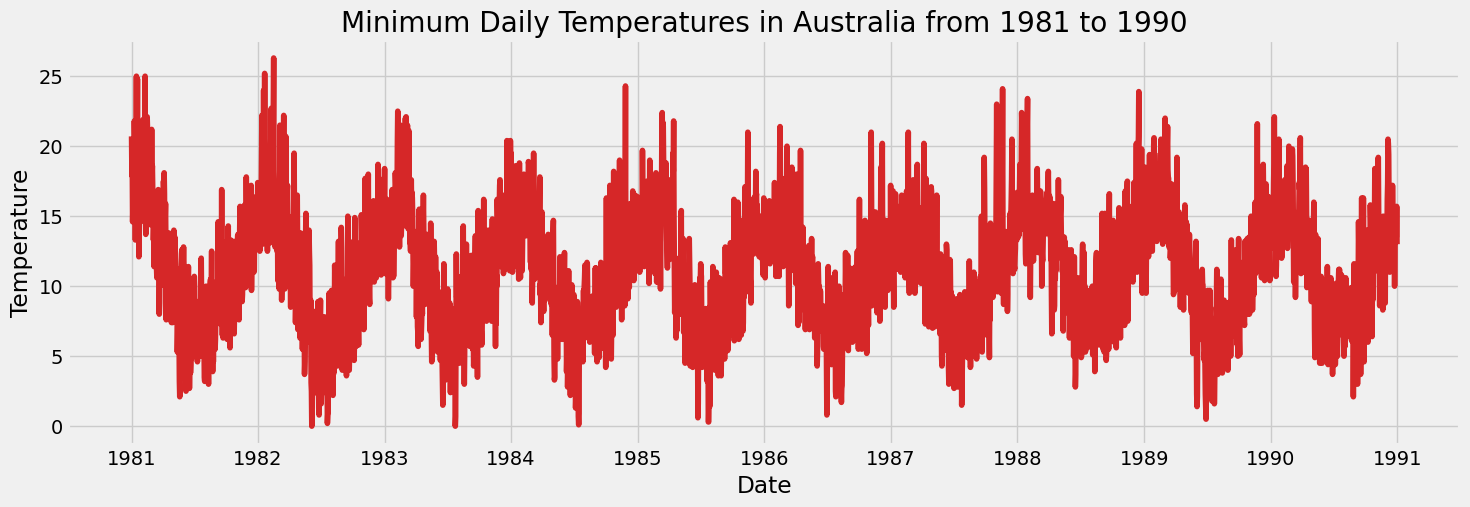

In [47]:
# Time Series Graph Plot of Minimum Daily Temperatures in Australia
plt.figure(figsize=(16,5), dpi=100)
plt.plot(daily_min_temp_data['Date'], daily_min_temp_data['Temp'], color='tab:red')
plt.gca().set(title='Minimum Daily Temperatures in Australia from 1981 to 1990', 
              xlabel='Date', ylabel='Temperature')
plt.show()

<Figure size 1152x576 with 0 Axes>

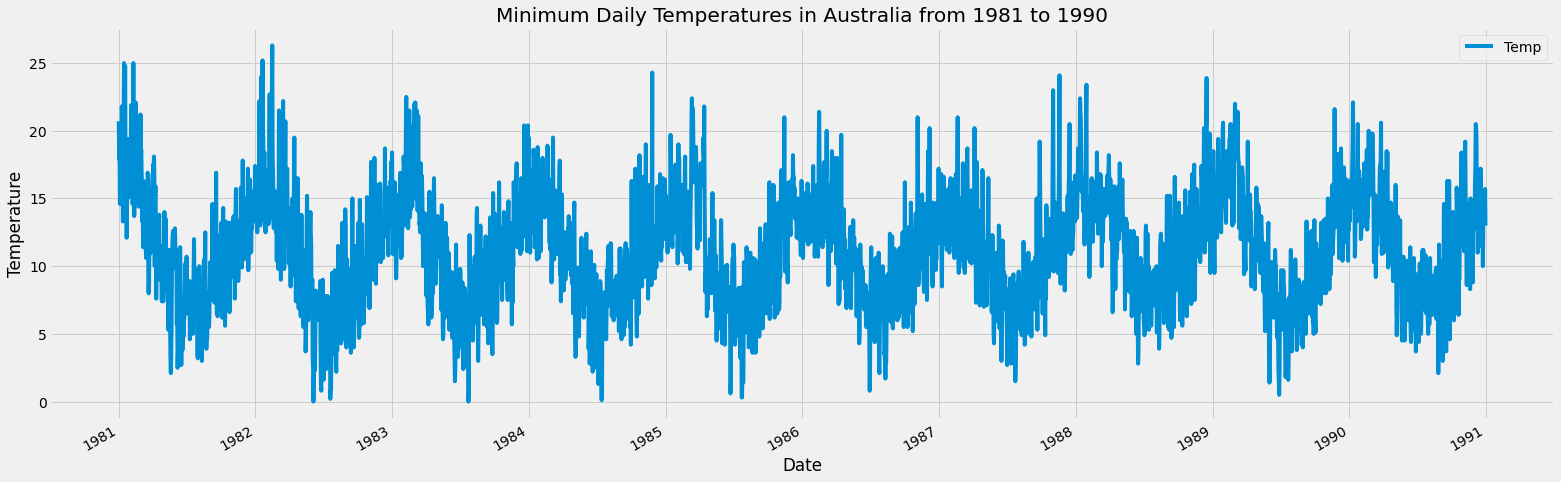

<Figure size 1152x576 with 0 Axes>

In [48]:
# Another way to plot same graph of time series
daily_min_temp_data.plot(x = 'Date', y = 'Temp', subplots=True, grid=True, figsize=(24,8))
plt.title('Minimum Daily Temperatures in Australia from 1981 to 1990')
plt.ylabel('Temperature')
plt.figure(figsize=(16,8))

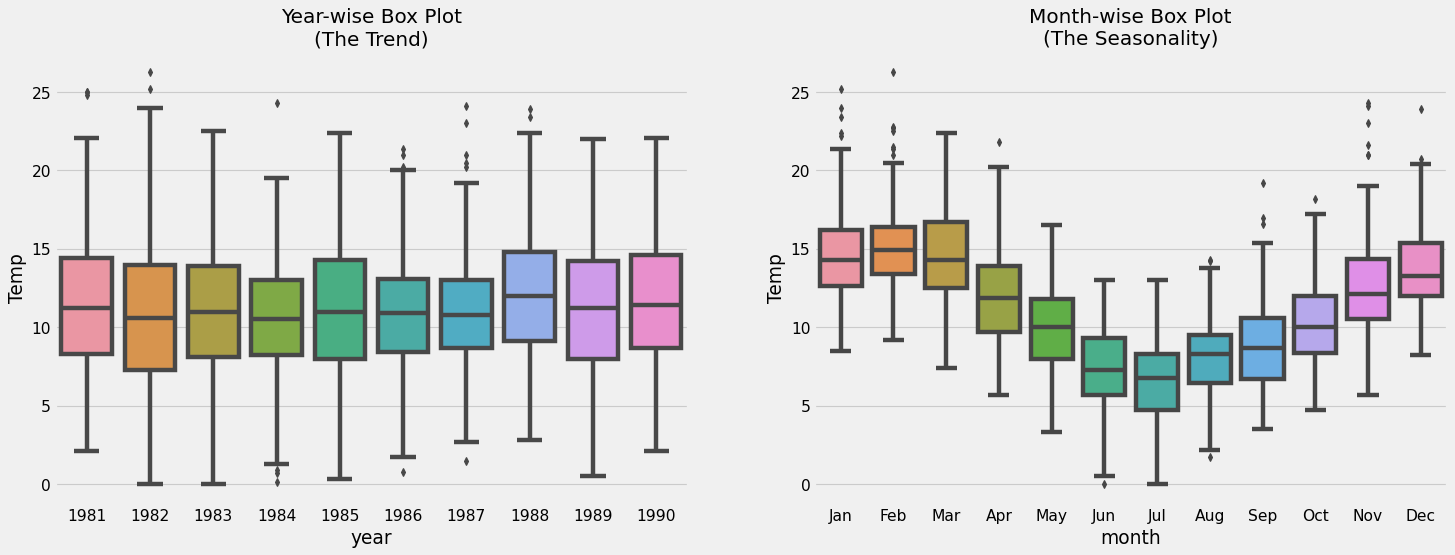

In [49]:
# Boxplot Displaying Seasonality of Minimum Daily Temperatures in Australia (Between Years and Between Months Within a Year)
daily_min_temp_data['year'] = [d.year for d in daily_min_temp_data.Date]
daily_min_temp_data['month'] = [d.strftime('%b') for d in daily_min_temp_data.Date]
years = daily_min_temp_data['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Temp', data=daily_min_temp_data, ax=axes[0])
sns.boxplot(x='month', y='Temp', data=daily_min_temp_data.loc[~daily_min_temp_data.year.isin([1981, 1990]), :])

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Observed, Trend, Seasonal, and Residual Plots of Daily Minimum Temperatures

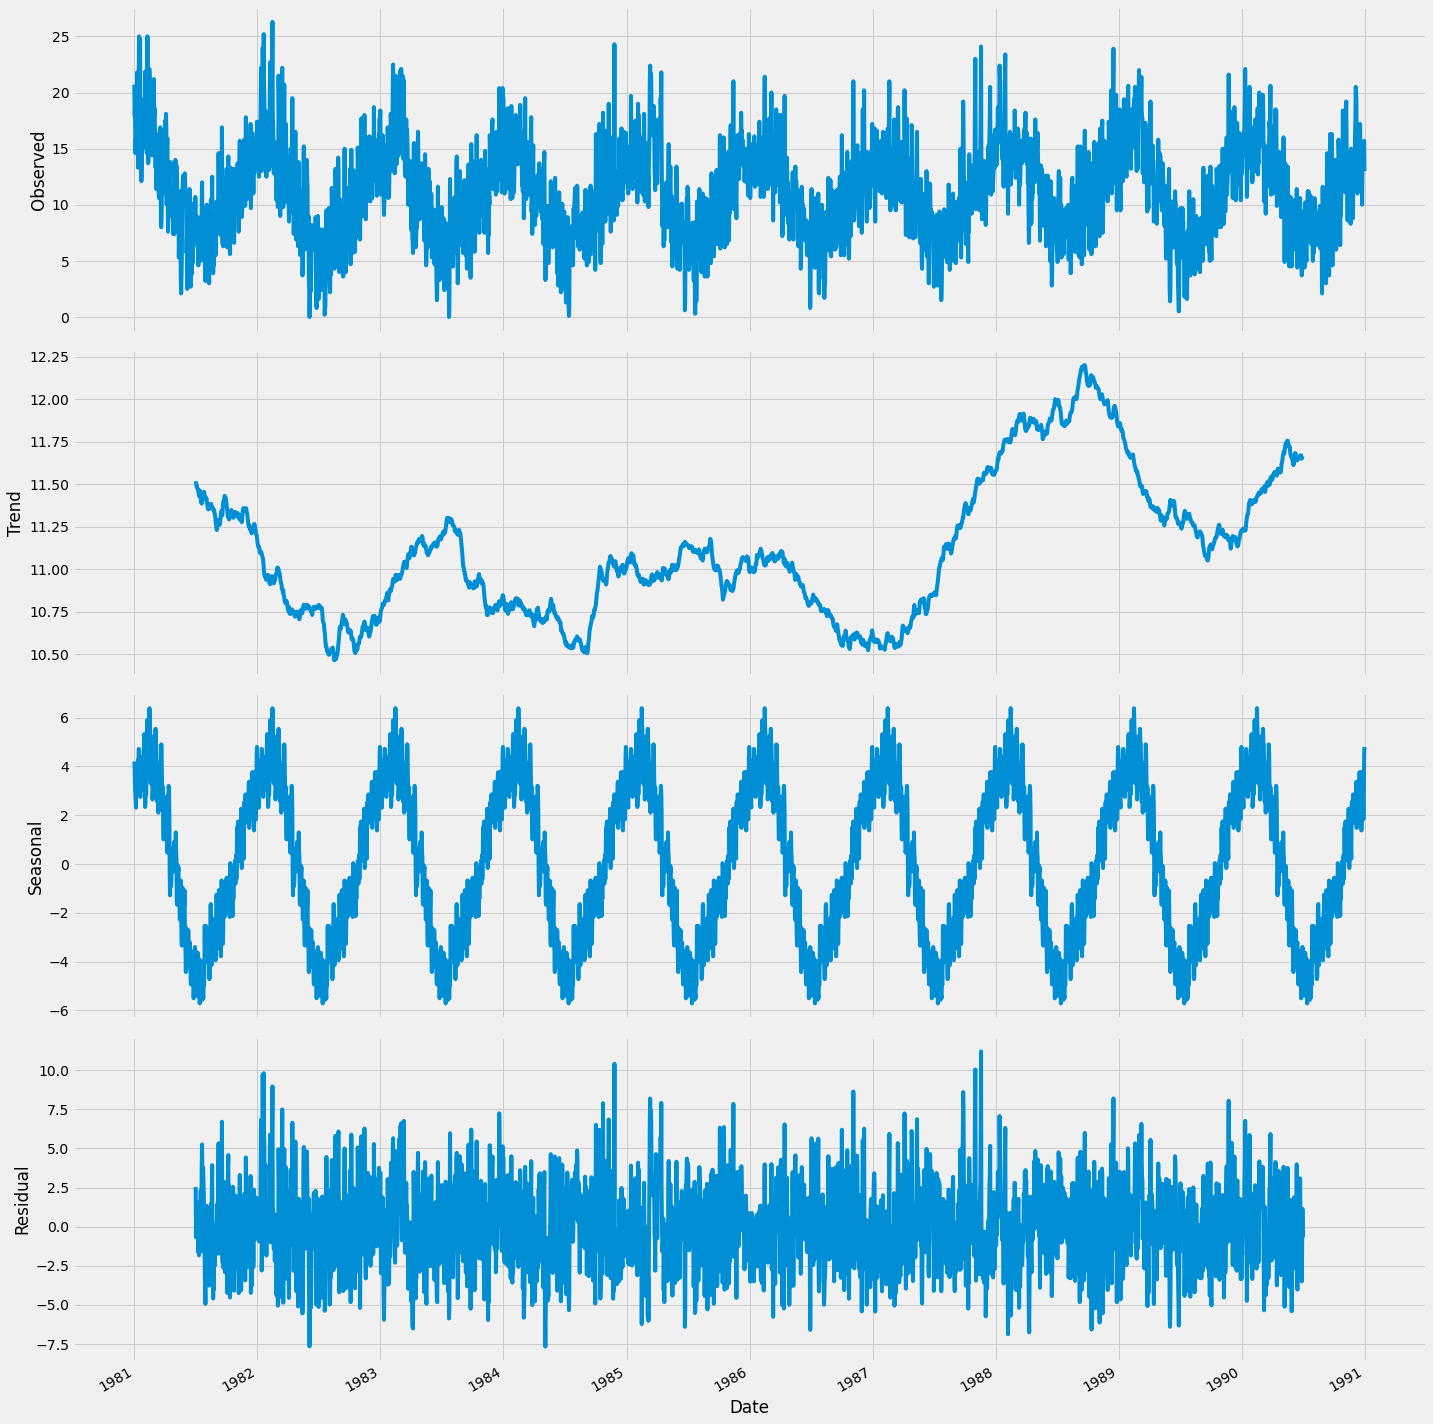

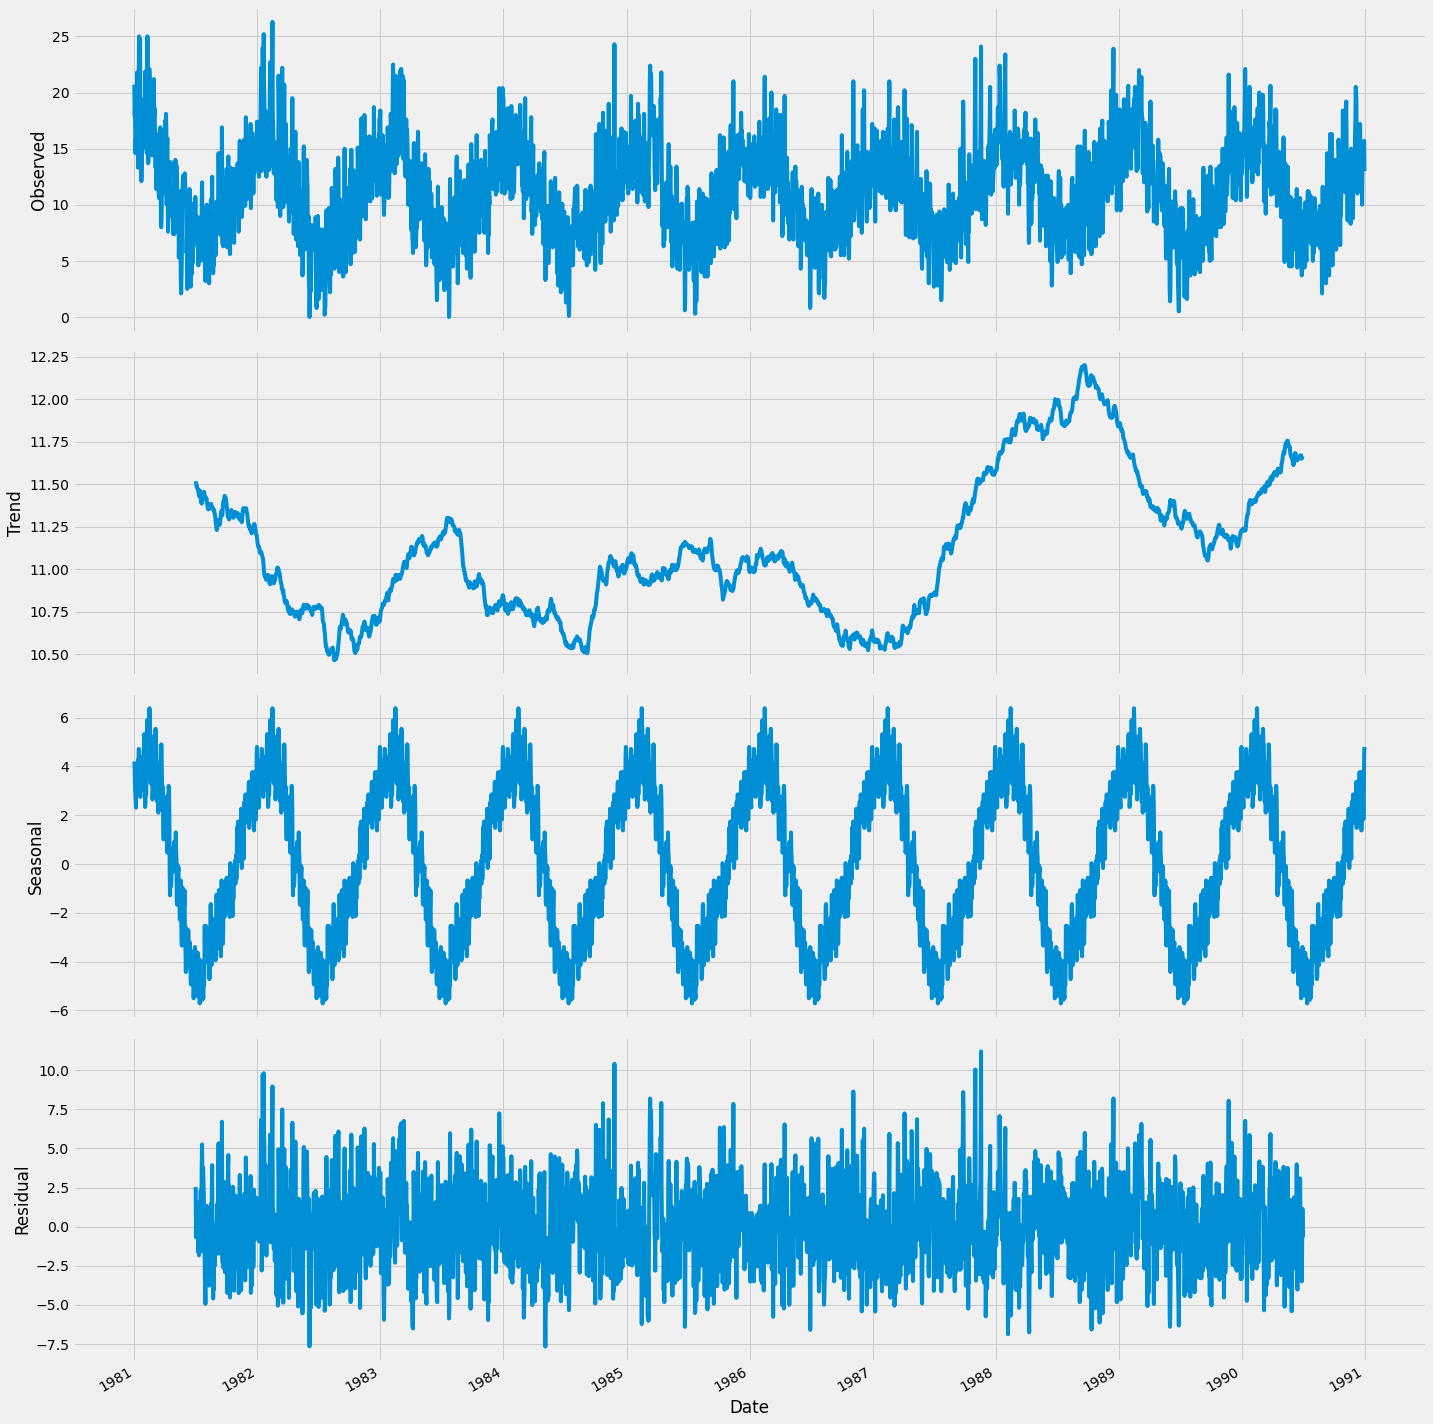

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas.util.testing as tm
daily_min_temp_data.set_index('Date', inplace = True)
seasonal = seasonal_decompose(daily_min_temp_data['Temp'], freq = 365)
plt.rcParams["figure.figsize"]=(20, 20)
seasonal.plot()

Time Series Forecasting of Minimum Daily Temperatures in Australia Using LSTM RNN Model

In [51]:
# Setting df as Temperature column with Date Index
df = daily_min_temp_data["Temp"]

In [52]:
# Inspection of first 5 rows of df 
pd.DataFrame(df).head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [53]:
# Inspection of last 5 rows of df 
pd.DataFrame(df).tail()

,Temp
Date,
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


In [54]:
# Defining time series generator and creating X and y arrays corresponding to past n days to predict next day
n_input = 10
n_features = 1
generator = TimeseriesGenerator(np.array(df), np.array(df), length = n_input, batch_size = 1)
X, y = generator[0]
print("X: ", X)
print("Using the past n Number of Days Given in this Array: \n", X.flatten())
print("    ")
print("y: ", y)
print("Predict this Value: \n", y.flatten())

X:  [[20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20. ]]
Using the past n Number of Days Given in this Array: 
 [20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20. ]
    
y:  [16.2]
Predict this Value: 
 [16.2]


In [55]:
# First 5 Examples of Generators (using last n daily temperatures to predict next temperature value)
generator[0], generator[1], generator[2], generator[3], generator[4]

((array([[20.7, 17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. ]]),
  array([16.2])),
 (array([[17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. , 16.2]]),
  array([13.3])),
 (array([[18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. , 16.2, 13.3]]),
  array([16.7])),
 (array([[14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20. , 16.2, 13.3, 16.7]]),
  array([21.5])),
 (array([[15.8, 15.8, 15.8, 17.4, 21.8, 20. , 16.2, 13.3, 16.7, 21.5]]),
  array([25.])))

In [56]:
# Separating X matrix of previous n values from y array of value predictions
X = []
y = []
for i in range(len(generator) - 1):
  X.append(generator[i][0])
  y.append(generator[i][1])

In [57]:
# Converting both lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [58]:
# Inspection and Shape of X
print("Shape of X is: ", X.shape)
print(X[0:5])
print("    ")

# Reshape X from (len(X), 1, n_input) to (len(X), n_input, 1))
X = np.reshape(X, (len(X), n_input, 1))
print("Shape of X AFTER reshaping is: ", X.shape)
print(X[0])

Shape of X is:  (3639, 1, 10)
[[[20.7 17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20. ]]

 [[17.9 18.8 14.6 15.8 15.8 15.8 17.4 21.8 20.  16.2]]

 [[18.8 14.6 15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3]]

 [[14.6 15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7]]

 [[15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7 21.5]]]
    
Shape of X AFTER reshaping is:  (3639, 10, 1)
[[20.7]
 [17.9]
 [18.8]
 [14.6]
 [15.8]
 [15.8]
 [15.8]
 [17.4]
 [21.8]
 [20. ]]


In [59]:
# Inspection and Shape of y
print("Shape of y is: ", y.shape)
print(y[0:5])
print("    ")

# Reshape y from (len(X), 1) to (len(X)))
y = np.reshape(y, (len(X)))
print("Shape of y AFTER reshaping is: ", y.shape)
print(y[0:5])

Shape of y is:  (3639, 1)
[[16.2]
 [13.3]
 [16.7]
 [21.5]
 [25. ]]
    
Shape of y AFTER reshaping is:  (3639,)
[16.2 13.3 16.7 21.5 25. ]


In [60]:
# # split training vs test dataset (predicting minimum daily temperatures in last 20% of Data Time Series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.10, shuffle=False) # Not random shuffle since I want order to remain same in time series

In [61]:
# Shapes of All of X_train, y_train, X_test, y_test
print("X_train shape is: ", X_train.shape)
print("y_train shape is: ", y_train.shape)
print("X_test shape is: ", X_test.shape)
print("y_test shape is: ", y_test.shape)

X_train shape is:  (3275, 10, 1)
y_train shape is:  (3275,)
X_test shape is:  (364, 10, 1)
y_test shape is:  (364,)


In [62]:
# Scaling train and test datasets using Minimum - Maximum Scaler
# scaler = MinMaxScaler()
# scaled_train = scaler.fit_transform(np.array(train).reshape(-1, 1))
# scaled_test = scaler.transform(np.array(test).reshape(-1, 1))

In [63]:
# Train values scaled
# scaled_train[0:5]

In [64]:
# Test values scaled 
# scaled_test[0:5]

In [65]:
# Build LSTM model
model = Sequential()
# model.add(InputLayer((n_input, n_features)))
# model.add(LSTM(64))
# model.add(LSTM(64, activation='relu'))
model.add(LSTM(64, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

In [66]:
# Summary of the LSTM model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Compiling and Fitting the model (also model checkpoint to find best model based on lowest RMSE/MSE)
check_point = ModelCheckpoint('model/', save_best_only=True)
model.compile(optimizer=Adam(learning_rate = 0.0001), loss = MeanSquaredError(), metrics = RootMeanSquaredError())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
103/103 [==============================] - 2s 10ms/step - loss: 144.3333 - root_mean_squared_error: 12.0139 - val_loss: 128.2598 - val_root_mean_squared_error: 11.3252
Epoch 2/10
103/103 [==============================] - 1s 7ms/step - loss: 45.2877 - root_mean_squared_error: 6.7296 - val_loss: 6.4916 - val_root_mean_squared_error: 2.5479
Epoch 3/10
103/103 [==============================] - 1s 7ms/step - loss: 8.1551 - root_mean_squared_error: 2.8557 - val_loss: 6.7453 - val_root_mean_squared_error: 2.5972
Epoch 4/10
103/103 [==============================] - 1s 7ms/step - loss: 7.3035 - root_mean_squared_error: 2.7025 - val_loss: 5.4350 - val_root_mean_squared_error: 2.3313
Epoch 5/10
103/103 [==============================] - 1s 10ms/step - loss: 6.8659 - root_mean_squared_error: 2.6203 - val_loss: 5.4358 - val_root_mean_squared_error: 2.3315
Epoch 6/10
103/103 [==============================] - 1s 7ms/step - loss: 6.6695 - root_mean_squared_error: 2.5825 - val_loss: 5.27

Text(0, 0.5, 'Loss')

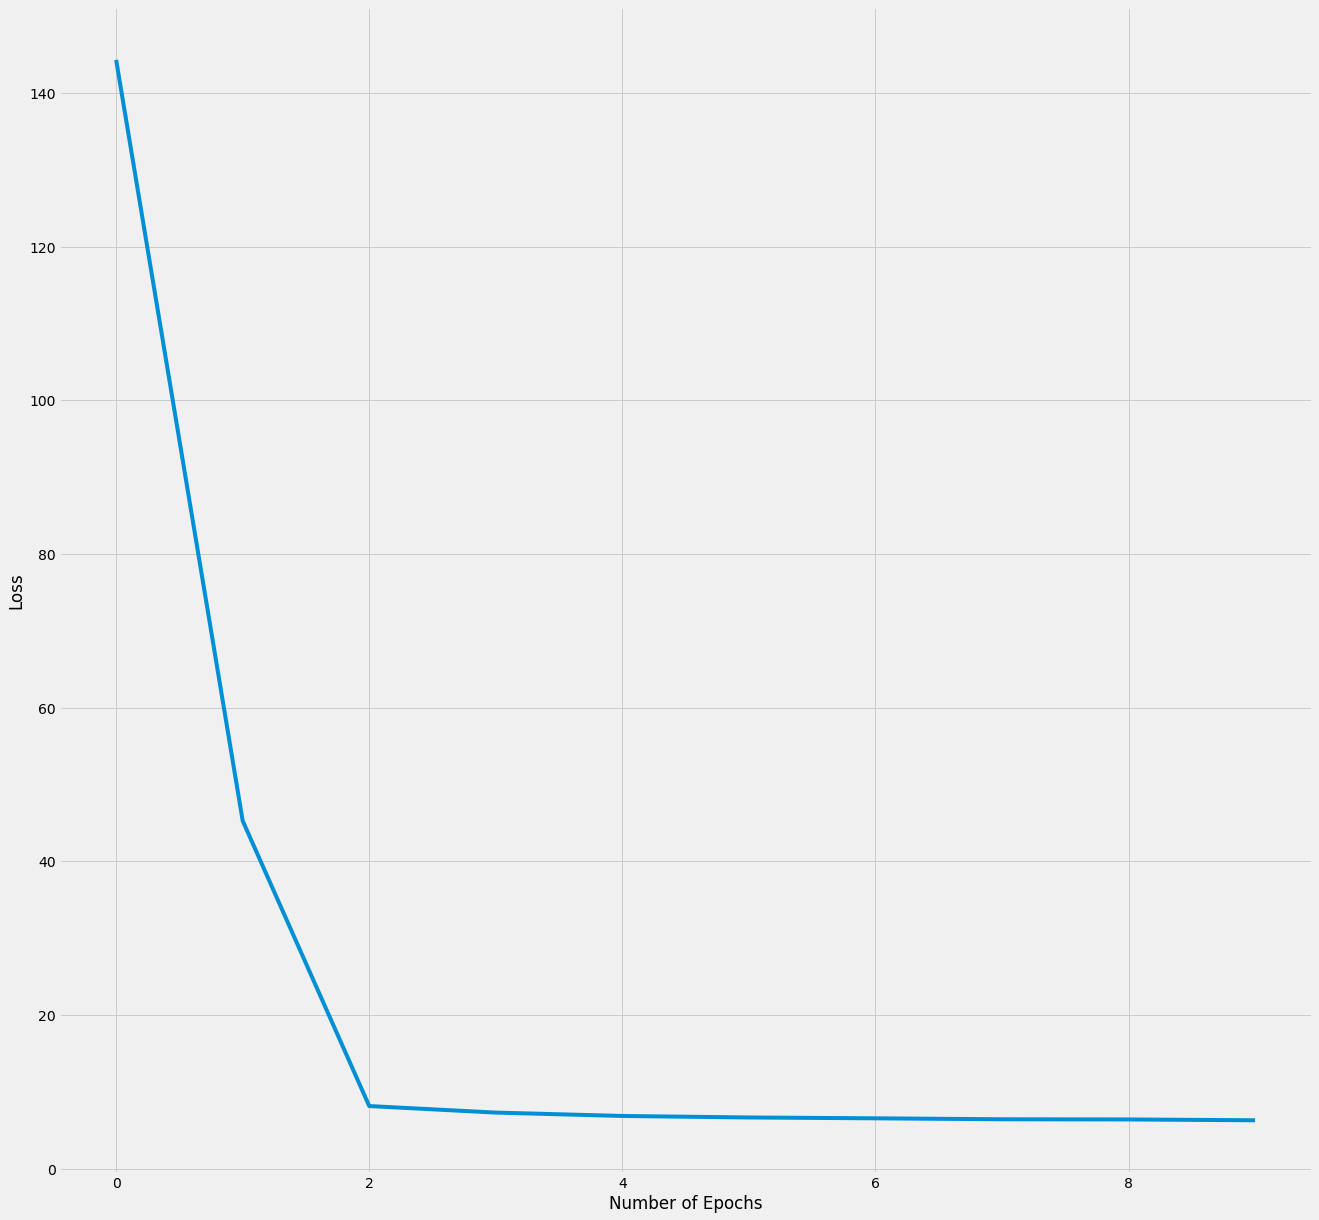

In [68]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")

In [69]:
# Making Predictions with Model on X_train
predictions = model.predict(X_train).flatten()
train_predictions = pd.DataFrame(data = {"Predictions": predictions, "Actual": y_train})
train_predictions['Date'] = daily_min_temp_data.index[n_input:len(train_predictions)+n_input]
train_predictions.set_index("Date", inplace = True)
print(train_predictions.shape)
print("    ")
train_predictions

(3275, 2)
    


,Predictions,Actual
Date,,
1981-01-11,18.898655,16.2
1981-01-12,16.485439,13.3
1981-01-13,15.274644,16.7
1981-01-14,17.619194,21.5
1981-01-15,20.882374,25.0
...,...,...
1989-12-27,15.467309,13.3
1989-12-28,14.118535,11.7
1989-12-29,13.207355,10.4


Text(0, 0.5, 'Temperature')

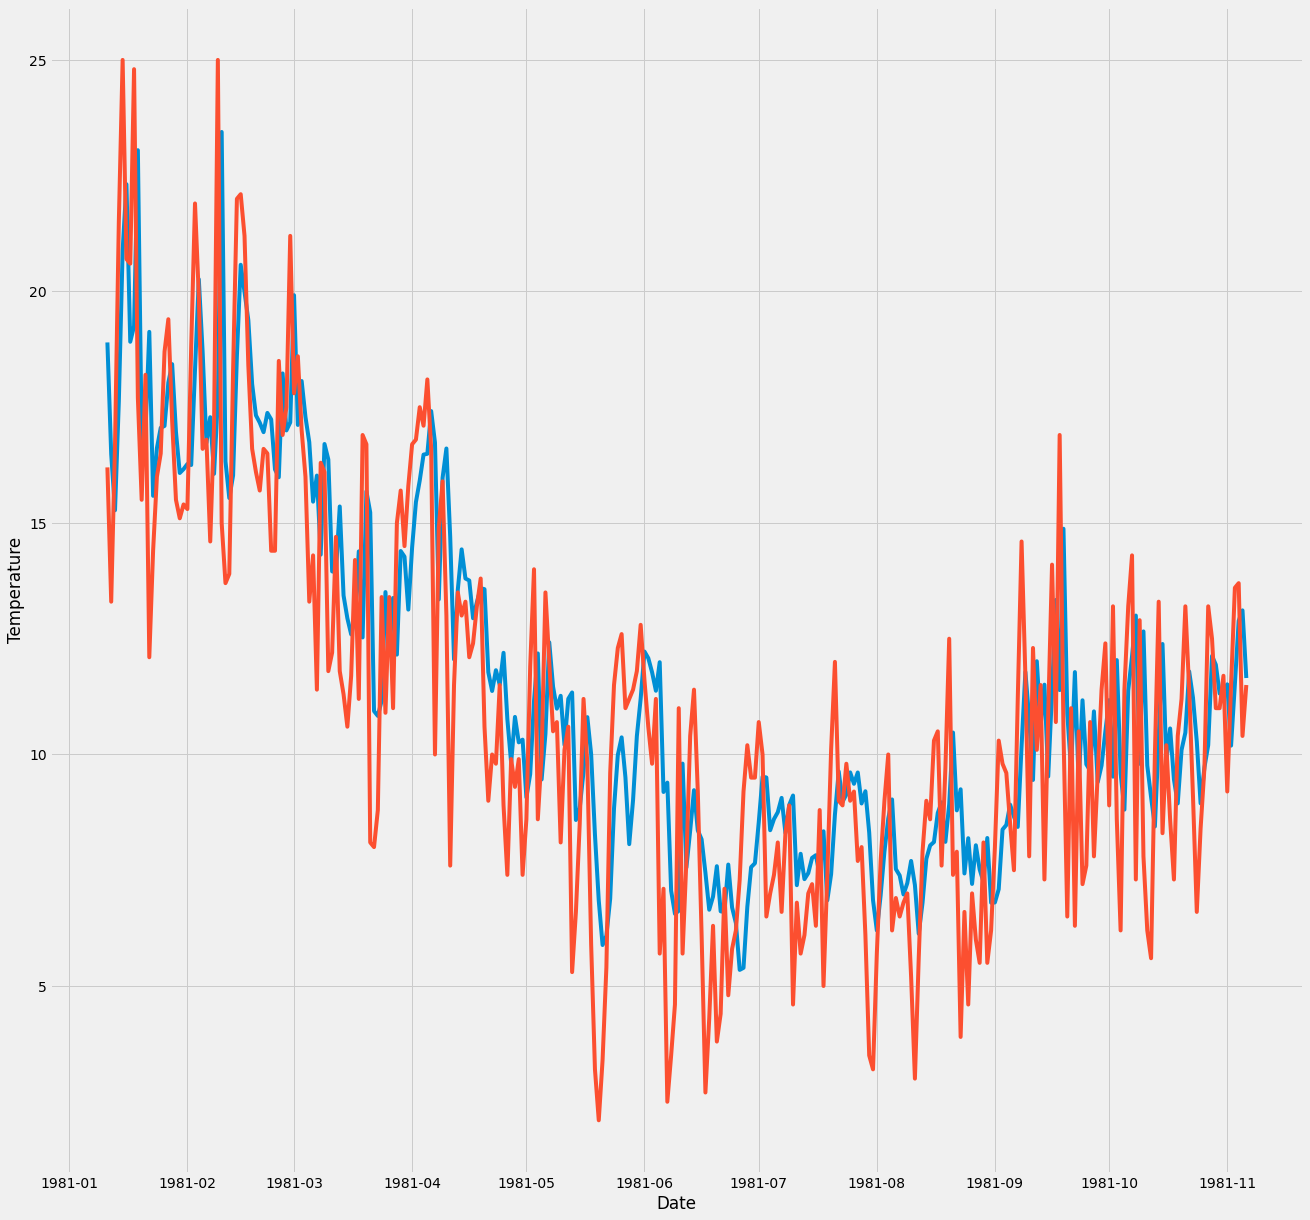

In [70]:
# Visualizing Train Predictions vs Actual Values for Training Data
plt.plot(train_predictions['Predictions'][0:300], label="Predictions")
plt.plot(train_predictions['Actual'][0:300], label="Actual")
plt.xlabel("Date")
plt.ylabel("Temperature")

In [71]:
# Making Predictions with Model on X_test
predictions = model.predict(X_test).flatten()
val_predictions = pd.DataFrame(data = {"Predictions": predictions, "Actual": y_test})
val_predictions['Date'] = daily_min_temp_data.index[-len(val_predictions)-1:-1]
val_predictions.set_index("Date", inplace = True)
print(val_predictions.shape)
print("    ")
val_predictions

(364, 2)
    


,Predictions,Actual
Date,,
1990-01-01,13.473414,14.8
1990-01-02,14.681680,13.3
1990-01-03,14.028142,15.6
1990-01-04,15.407430,14.5
1990-01-05,14.634334,14.3
...,...,...
1990-12-26,13.944139,14.6
1990-12-27,14.988593,14.0
1990-12-28,14.503758,13.6


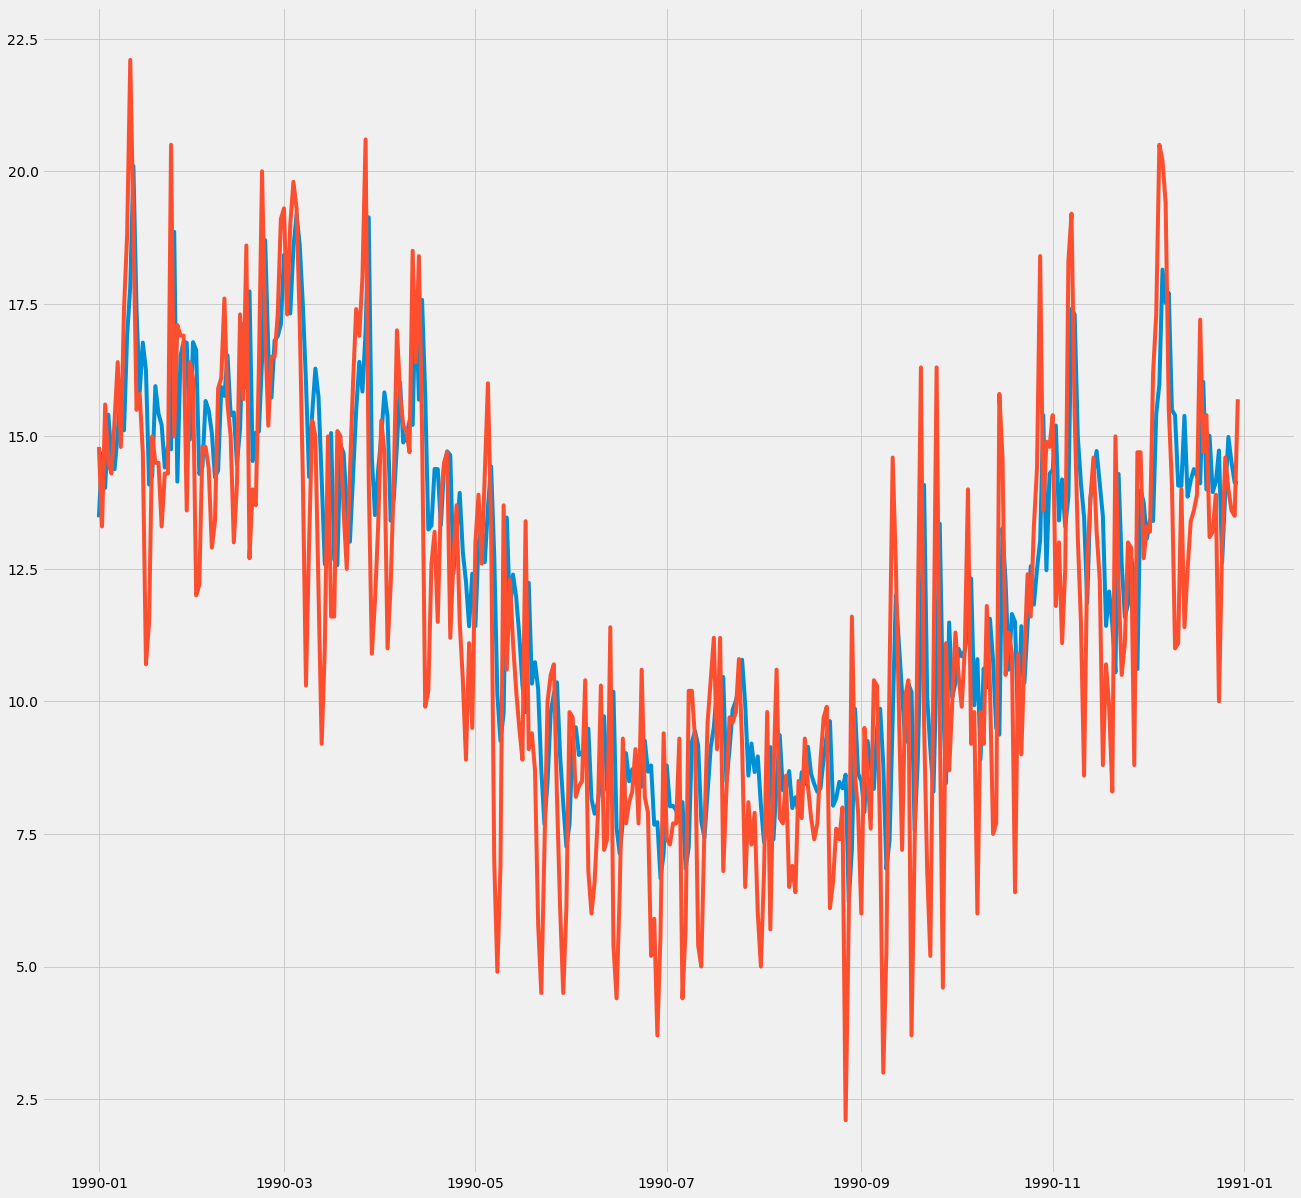

In [72]:
# Visualizing Test Predictions vs Actual Values for Testing Data
plt.plot(val_predictions['Predictions'], label="Predictions")
plt.plot(val_predictions['Actual'], label="Actual")
# plt.xlabel("Time")
# plt.ylabel("Temperature")

In [73]:
# Combining Train and Validation Dataframes
actual_vs_predicted_temps = train_predictions.append(val_predictions, ignore_index=True)

# Predictions start after previous n values
actual_vs_predicted_temps['Date'] = daily_min_temp_data.index[n_input:-1]
actual_vs_predicted_temps.set_index("Date", inplace = True)
actual_vs_predicted_temps

,Predictions,Actual
Date,,
1981-01-11,18.898655,16.2
1981-01-12,16.485439,13.3
1981-01-13,15.274644,16.7
1981-01-14,17.619194,21.5
1981-01-15,20.882374,25.0
...,...,...
1990-12-26,13.944139,14.6
1990-12-27,14.988593,14.0
1990-12-28,14.503758,13.6


Text(0, 0.5, 'Temperature')

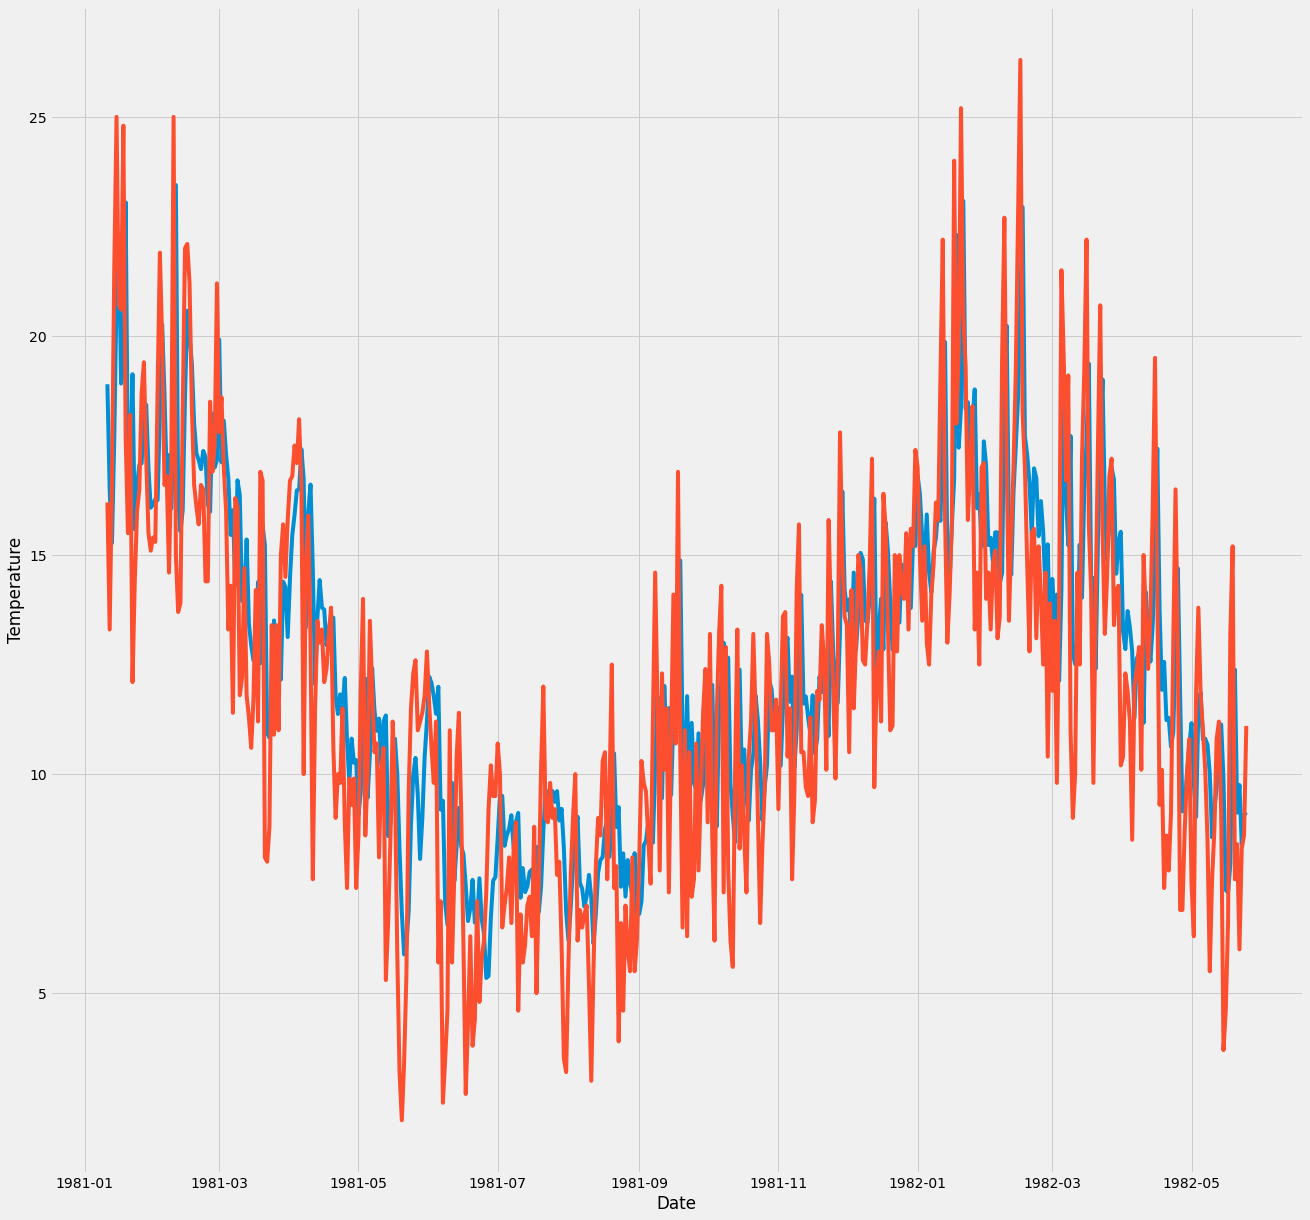

In [74]:
# Visualizing  Predictions vs Actual Values for ENTIRE Data of Temperatures
plt.plot(actual_vs_predicted_temps['Predictions'][0:500], label="Predictions")
plt.plot(actual_vs_predicted_temps['Actual'][0:500], label="Actual")
plt.xlabel("Date")
plt.ylabel("Temperature")